# 4.1 EDA

## Preparations

In [2]:
import pandas as pd
import numpy as np
import geopandas
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as cm
from matplotlib import pyplot
from matplotlib.collections import PolyCollection

import scipy.stats as stats
from scipy.stats.stats import spearmanr

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = ''
df = pd.read_csv(path+'Data/tripdata.csv', index_col=0)
df['datetime'] = pd.to_datetime(df[['pickup_year', 
                                    'pickup_month', 
                                    'pickup_day', 
                                    'pickup_hour']].rename(columns={'pickup_year': 'year', 
                                                                    'pickup_month': 'month', 
                                                                    'pickup_day': 'day', 
                                                                    'pickup_hour':'hour'}))

In [ ]:
# Taxi zones
taxi_zones = geopandas.read_file(path+'Raw_data/taxi_zones/taxi_zones.shp')

## 3.1 Data

### 3.1.1 Background Information

In [ ]:
zones_top20 = df.groupby('PULocationID')['count'].sum().sort_values(ascending = False).head(21).sort_index()
zones_top20 = zones_top20.drop(138) # Top 20 zones in Manhatten

In [ ]:
taxi_zones.loc[taxi_zones['LocationID'].isin(zones_top20.index), 'top20_MH'] = 'Top 20 Manhatten'
taxi_zones.loc[~taxi_zones['LocationID'].isin(zones_top20.index), 'top20_MH'] = 'Other'

taxi_zones_top20 = taxi_zones[taxi_zones['top20_MH']=='Top 20 Manhatten']
taxi_zones_top20['count'] = zones_top20.values

In [ ]:
# Plot of the selected Taxi Zones
custom_cmap = cm.colors.ListedColormap(['#000000', 
                                        '#86BC25'])

fig, axes = plt.subplots(ncols = 2, figsize = (15, 12))
taxi_zones.plot("top20_MH", 
                legend = True, 
                ax = axes[0], 
                cmap = custom_cmap, 
                legend_kwds = {'loc':'upper left', 
                               'fontsize':'x-large'})

# Plot of number of trips in the selected taxi zones
taxi_zones_top20.plot('count', 
                      legend= True, 
                      ax = axes[1], 
                      cmap = 'summer', 
                      legend_kwds = {'label':'Trips', 
                                     'shrink':0.7})

axes[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
axes[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

for i, geo in taxi_zones_top20['geometry'].centroid.iteritems():
    axes[1].annotate(s=(i+1), xy=[geo.x, geo.y], 
                     color="black", 
                     fontsize = 12)

In [ ]:
df_top20 = df[df['PULocationID'].isin(zones_top20.index)]

In [ ]:
df_237 = df_top20[(df_top20['PULocationID']==237)]

### 3.1.2 Data Description

In [ ]:
# Plot of taxi demand in 237
# Day
df_237[(df_237['datetime']<'01-02-2009 00:00:00')].plot(x = 'datetime', 
                                                        y = 'count', 
                                                        legend = False, 
                                                        color = '#046A38', 
                                                        figsize = (6, 4), 
                                                        fontsize= 13)
plt.xlabel('Time', size=14)
plt.ylabel('Trips', size=14)

# Week
df_237[(df_237['datetime']<'01-08-2009 00:00:00')].plot(x = 'datetime', 
                                                        y = 'count', 
                                                        legend = False, 
                                                        color = '#046A38', 
                                                        figsize = (6, 4), 
                                                        fontsize= 13)
plt.xlabel('Day', size=14)
plt.ylabel('Trips', size=14)

# Month
df_237[(df_237['datetime']<'02-01-2009 00:00:00')].plot(x = 'datetime', 
                                                        y = 'count', 
                                                        legend = False, 
                                                        color = '#046A38', 
                                                        figsize = (6, 4), 
                                                        fontsize= 13)
plt.xlabel('Day', size=14)
plt.ylabel('Trips', size=14)

# Year
df_237[(df_237['datetime']<'01-01-2010 00:00:00')].plot(x = 'datetime', 
                                                        y = 'count', 
                                                        legend = False, 
                                                        color = '#046A38', 
                                                        figsize = (6, 4), 
                                                        fontsize= 13)
plt.xlabel('Month', size=14)
plt.ylabel('Trips', size=14)

# All time
df_237[(df_237['datetime']<'01-01-2021 00:00:00')].plot(x = 'datetime', 
                                                        y = 'count', 
                                                        legend = False, 
                                                        color = '#046A38', 
                                                        figsize = (6, 4), 
                                                        fontsize= 13)
plt.xlabel('Year', size=14)
plt.ylabel('Trips', size=14)

## Features of the Time Series

In [ ]:
df_top20_total = df_top20.groupby(['pickup_year', 
                                   'pickup_month', 
                                   'pickup_day'], 
                                  as_index = False).sum()
df_top20_total.index = pd.to_datetime(df_top20_total[['pickup_year', 
                                                      'pickup_month', 
                                                      'pickup_day']].rename(columns={'pickup_year': 'year', 
                                                                                     'pickup_month': 'month', 
                                                                                     'pickup_day': 'day'}))
df_top20_total.index.freq = 'D'

In [ ]:
# Check correlation zone count and total count
df_top20_total_zones = df_top20.groupby(['pickup_year', 
                                         'pickup_month', 
                                         'pickup_day', 
                                         'PULocationID'], 
                                        as_index = False).sum()

correlations = []
for i in zones_top20.index:
    df_top20_minus_i = df_top20[df_top20['PULocationID']!=i].groupby(['pickup_year', 
                                                                      'pickup_month', 
                                                                      'pickup_day'], 
                                                                   as_index = False).sum()
    correlations.append(spearmanr(df_top20_minus_i['count'], 
                                  df_top20_total_zones[df_top20_total_zones['PULocationID']==i]['count'])[0])

taxi_zones_top20['correlation']=correlations

ax = taxi_zones_top20.plot('correlation', 
                           legend= True, 
                           cmap = 'summer', 
                           legend_kwds = {'label':"spearman's correlation", 
                                          'shrink':1}, 
                           figsize = (10, 8))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

for i, geo in taxi_zones_top20['geometry'].centroid.iteritems():
    ax.annotate(s=(i+1), xy=[geo.x, geo.y], 
                color="black", 
                fontsize= 12)

In [ ]:
# Boxplot of number of taxi trips
boxprops = dict(color = '#86BC25')
medianprops = dict(color = '#046A38')
whiskerprops = dict(color = '#046A38')
flierprops = dict(markersize = 3)

ax = df_top20.boxplot(column = 'count', 
                      by = 'PULocationID', 
                      fontsize = 13, 
                      figsize = (10,8), 
                      boxprops = boxprops, 
                      medianprops = medianprops, 
                      whiskerprops = whiskerprops, 
                      flierprops = flierprops)
ax.set_title('')
ax.set_gid('')
ax.set_xlabel('Taxi Zone', size = 14)
ax.set_ylabel('Trips', size = 14)
plt.suptitle('')

In [ ]:
# Distribution plots of taxi trips
df_top20.hist(column='count', 
              by = 'PULocationID', 
              figsize = (10, 15), 
              sharey = True, 
              sharex= False, 
              bins = 50, 
              color = '#046A38', 
              ylabelsize=12,
              xlabelsize = 12)

In [ ]:
df_top20_std = df_top20.groupby(['PULocationID', 
                                 'pickup_year', 
                                 'pickup_month', 
                                 'pickup_day'], 
                                as_index = False).std()[['PULocationID', 
                                                         'pickup_year', 
                                                         'pickup_month', 
                                                         'pickup_day', 
                                                         'count']]
df_top20_std['count2'] = df_top20.groupby(['PULocationID', 
                                           'pickup_year', 
                                           'pickup_month', 
                                           'pickup_day']
                                          , as_index = False).sum()['count']
df_top20_std.columns = ['PULocationID', 'year', 'month', 'day', 'std', 'count']
df_top20_std['std_log'] = np.log(df_top20_std['std'])
df_top20_std['count_log'] = np.log(df_top20_std['count'])
df_top20_std['date'] = pd.to_datetime(df_top20_std[['year', 'month', 'day']])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


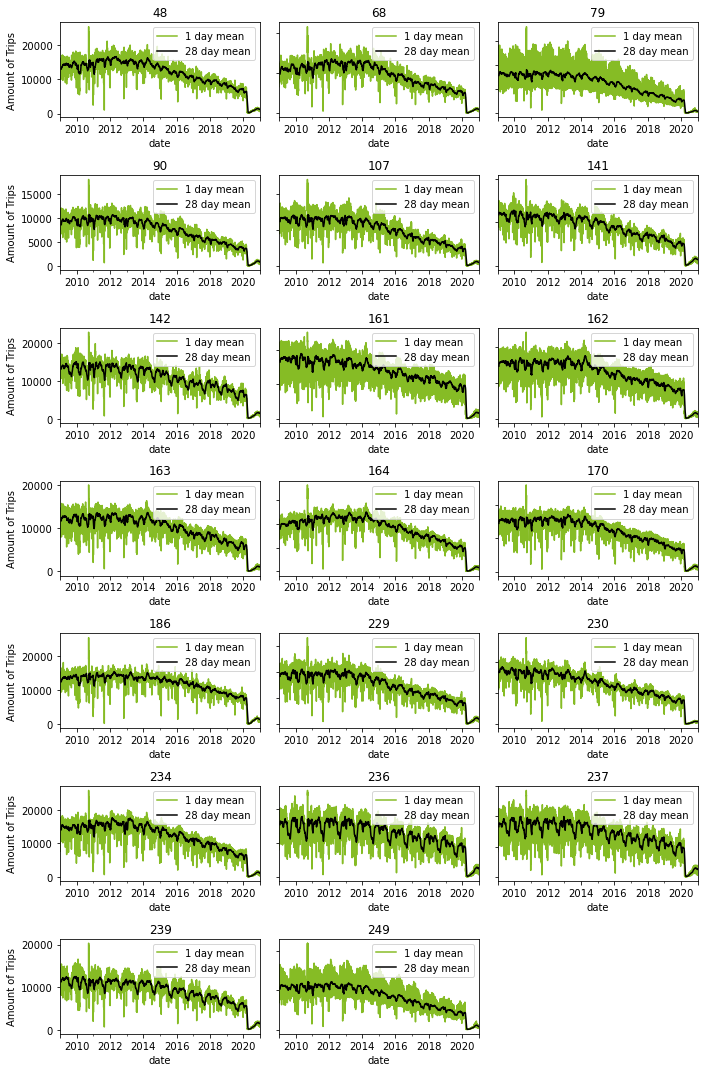

In [44]:
# Daily taxi trips and 28day mean
fig, axes = plt.subplots(7, 3, figsize= (10, 15))
row = 0
column = 0
for title, group in df_top20_std.groupby('PULocationID'):
    group.index = group['date']
    group.index.freq = 'D'
    rolmean_28 = pd.Series(group['count']).rolling(window=28).mean() 
    group.plot(x= 'date', 
               y ='count', 
               sharey= True, 
               legend = True, 
               ax = axes[row, column], 
               ylabel= 'Number of Trips',
               color = '#86BC25', 
               title = title,
               fontsize = 12)
    
    rolmean_28.plot(label='rolling 28 day mean', 
                    legend= True, ax = axes[row, column], 
                    color = '#000000')
    axes[row, column].legend(loc = 'upper right', labels = ['1 day mean', '28 day mean'])
    column = column + 1
    if column == 3:
        column = 0
        row = row + 1
    ax.legend()

fig.tight_layout()
fig.delaxes(ax = axes[6,2])
plt.show()

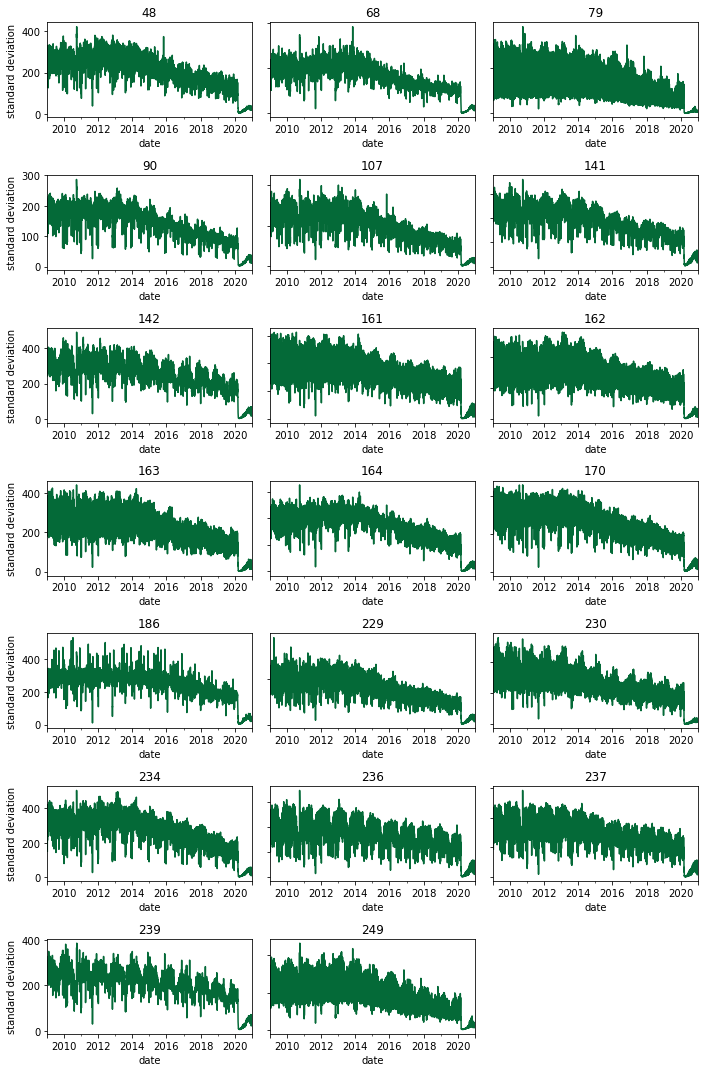

In [45]:
# Std taxi trips per taxi zone
fig, axes = plt.subplots(7, 3, figsize= (10, 15))
row = 0
column = 0
for title, group in df_top20_std.groupby('PULocationID'):
    group.plot(x= 'date', 
               y ='std', 
               legend = False, 
               sharey = True, 
               ax = axes[row, column], 
               ylabel= 'standard deviation', 
               color = '#046A38', 
               title = title,
               fontsize = 12)
    column = column + 1
    if column == 3:
        column = 0
        row = row + 1

fig.tight_layout()
fig.delaxes(ax = axes[6,2])
plt.show() 

Text(0, 0.5, 'Residual')

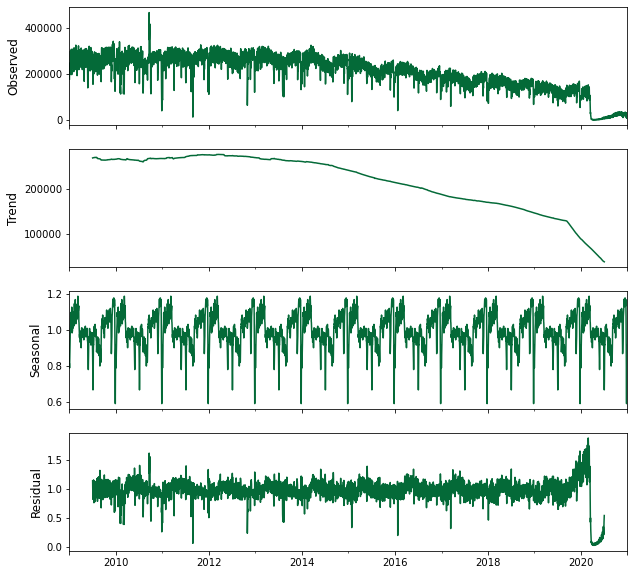

In [46]:
# Seasonality in the Time Series
result = seasonal_decompose(df_top20_total['count'], model = 'multiplicative', freq = 365)
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (10,10))

result.observed.plot(ax=axes[0], legend=False, color='#046A38', fontsize = 13)
axes[0].set_ylabel('Observed', fontsize = 13)
result.trend.plot(ax=axes[1], legend=False, color='#046A38', fontsize = 13)
axes[1].set_ylabel('Trend', fontsize = 13)
result.seasonal.plot(ax=axes[2], legend=False, color = '#046A38', fontsize = 13)
axes[2].set_ylabel('Seasonal', fontsize = 13)
result.resid.plot(ax=axes[3], legend=False, color='#046A38', fontsize = 13)
axes[3].set_ylabel('Residual', fontsize = 13)

In [47]:
ljung_p = np.mean(sm.stats.acorr_ljungbox(x=result.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


In [48]:
sm.stats.acorr_ljungbox(x=result.resid.dropna())

(array([ 2858.44780543,  4696.27460168,  6076.66516268,  7355.46311561,
         8850.35509121, 10921.86592185, 13409.77425597, 15382.26209818,
        16688.63775965, 17698.05093497, 18660.33055946, 19806.36873837,
        21472.14883909, 23507.99209265, 25108.58644976, 26140.49964391,
        26917.02201627, 27657.49731863, 28564.53225225, 29918.60236148,
        31599.57382377, 32899.55294202, 33708.38501961, 34303.76524057,
        34865.95341592, 35557.21374003, 36644.34367315, 38019.10159504,
        39041.80118098, 39633.76055901, 40042.18644442, 40424.05745227,
        40924.77944522, 41734.91023149, 42780.25191295, 43509.05951762,
        43890.84905687, 44131.05985388, 44341.71950791, 44641.2781567 ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]))

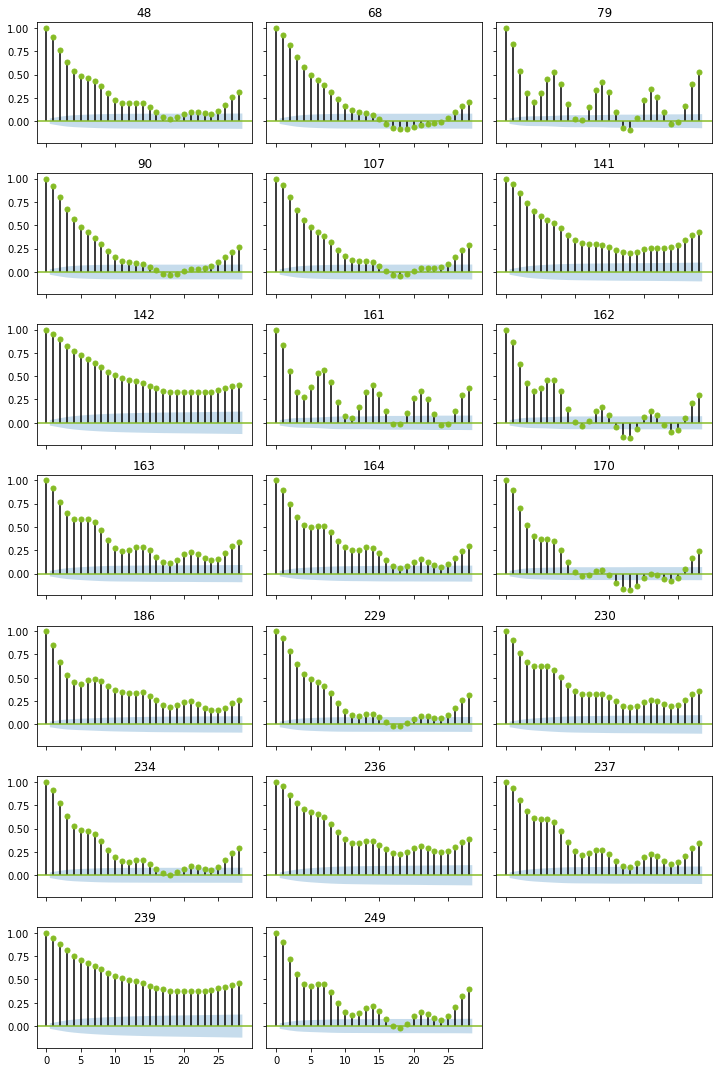

In [49]:
# Autocorrelation Function Plots
fig, axes = plt.subplots(7, 3, figsize= (10, 15), sharey = True, sharex = True)
row = 0
column = 0
for title, group in df_top20.groupby(['PULocationID', 
                                      'pickup_year', 
                                      'pickup_month', 
                                      'pickup_day'], 
                                     as_index = False).sum().groupby('PULocationID'):
    result = seasonal_decompose(group['count'], model = 'multiplicative', freq = 365)
    plot_acf(result.seasonal,  
             ax = axes[row, column], 
             lags = 28, 
             color = '#86BC25', 
             vlines_kwargs = {"colors":'#000000'}, 
             title = title)
    column = column + 1
  
    if column == 3:
        column = 0
        row = row + 1

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#86BC25')
fig.tight_layout()
fig.delaxes(ax = axes[6,2])
plt.show()

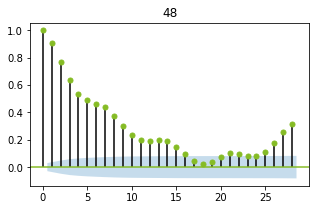

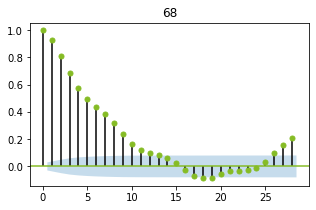

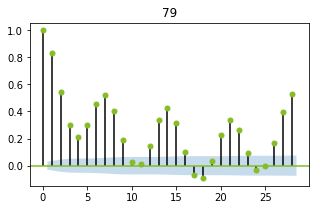

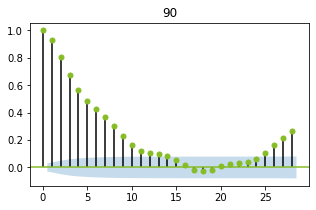

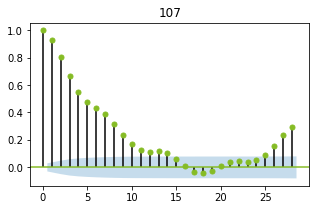

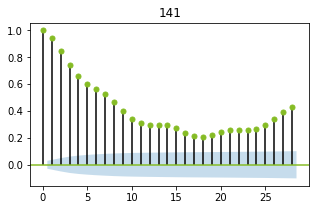

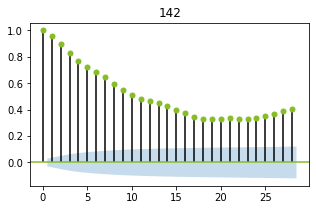

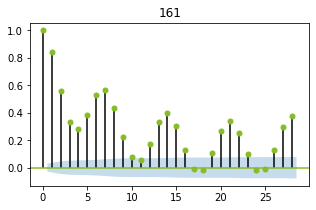

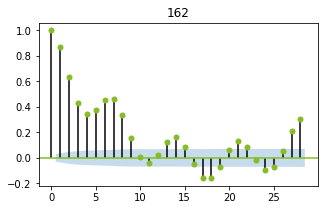

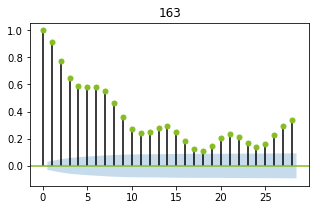

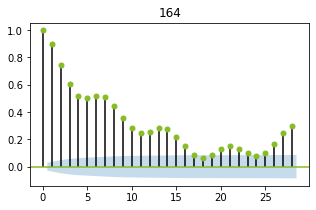

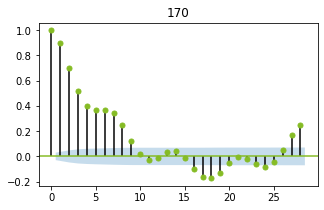

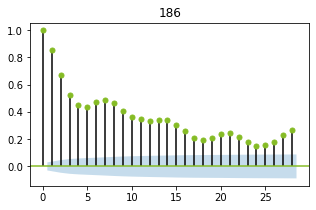

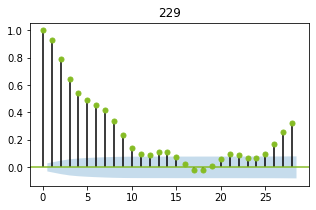

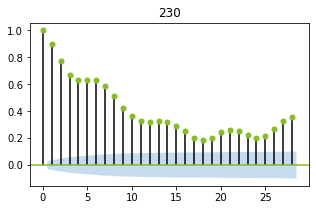

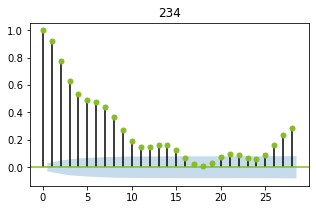

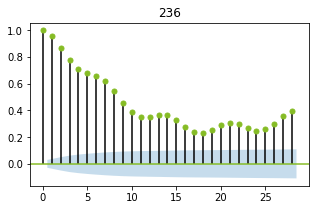

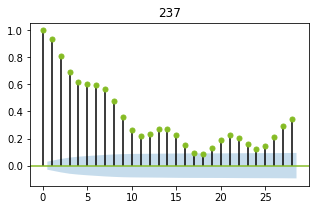

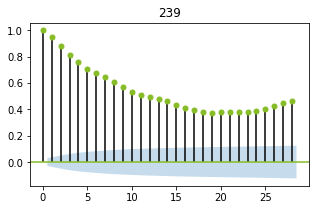

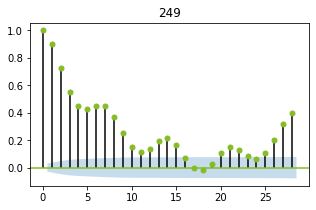

In [50]:
from matplotlib.collections import PolyCollection

for title, group in df_top20.groupby(['PULocationID', 
                                      'pickup_year', 
                                      'pickup_month', 
                                      'pickup_day'], as_index = False).sum().groupby('PULocationID'):
    result = seasonal_decompose(group['count'], 
                                model = 'multiplicative', 
                                freq = 365)
    fig = plot_acf(result.seasonal, 
                   lags = 28, 
                   color = '#86BC25', 
                   vlines_kwargs = {"colors":'#000000'}, 
                   title = title)
    fig.set_size_inches(5, 3)
    
    for item in ax.collections:
        if type(item)==PolyCollection:
            item.set_facecolor('#86BC25')

## Stationarity Tests

In [52]:
ADF_test_statistic = []
ADF_p_value = []
KPSS_test_statistic = []
KPSS_p_value = []
for i in zones_top20.index:
    daily_zone = df_top20[(df_top20['PULocationID']==i)].groupby(['pickup_year', 
                                                                  'pickup_month', 
                                                                  'pickup_day'], 
                                                                 as_index = False).sum()['count']
  
    ADF_result  = adfuller(daily_zone)
    ADF_test_statistic.append(ADF_result[0])
    ADF_p_value.append(ADF_result[1])
  
    kpps_result = kpss(daily_zone, regression='ct')
    KPSS_test_statistic.append(kpps_result[0])
    KPSS_p_value.append(kpps_result[1])

In [53]:
stationarity_tests = pd.DataFrame([zones_top20.index, 
                                   np.round(ADF_test_statistic, 3), 
                                   np.round(ADF_p_value, 3), 
                                   np.round(KPSS_test_statistic, 3), KPSS_p_value]).T
stationarity_tests.columns = ['zone',
                              'ADF_test_statitistc', 
                              'ADF_p_value', 
                              'KPSS_test_statistic', 
                              'KPSS_p_value']

In [54]:
print(stationarity_tests.to_latex(index = False))

\begin{tabular}{rrrrr}
\toprule
 zone &  ADF\_test\_statitistc &  ADF\_p\_value &  KPSS\_test\_statistic &  KPSS\_p\_value \\
\midrule
 48.0 &               -0.223 &        0.936 &                2.356 &          0.01 \\
 68.0 &               -0.793 &        0.821 &                2.495 &          0.01 \\
 79.0 &               -0.407 &        0.909 &                2.565 &          0.01 \\
 90.0 &               -0.661 &        0.857 &                2.290 &          0.01 \\
107.0 &               -0.853 &        0.803 &                2.256 &          0.01 \\
141.0 &               -0.974 &        0.763 &                1.822 &          0.01 \\
142.0 &               -1.416 &        0.575 &                1.561 &          0.01 \\
161.0 &               -0.977 &        0.761 &                1.535 &          0.01 \\
162.0 &               -0.773 &        0.827 &                1.980 &          0.01 \\
163.0 &               -0.750 &        0.833 &                2.116 &          0.01 \\
164.0